In [5]:
import numpy as np
import pandas as pd
import seaborn as sns

# <h2>Assessing Accuracy of Clusters</h2>

In [6]:
#temp = pd.read_csv('embeddings/250_0.16_vectors.tsv', sep=' ', header=None, skiprows=1)
temp = pd.read_csv("/h/224/stevenhl/chess_dim_skill/src/word2vecf/vectors/size_alpha/vecs_0.16_265.txt", sep=' ', header=None, skiprows=1)
temp = temp.drop(len(temp.columns)-1,axis=1)
#problem_id = list(temp[0])
temp.rename(columns={0:'puzzle_id'}, inplace=True)
temp.set_index('puzzle_id',inplace=True)
temp = temp.divide(np.linalg.norm(temp, axis=1), axis=0)

In [7]:
tag_data = pd.read_csv('/w/225/1/chess/tactics/tactics_problem.csv')
def get_first_tag(row):
    tags = str(row['tags']).split(',')
    return tags[0]

tag_data['tags'] = tag_data.apply(lambda row: get_first_tag(row),axis=1)
#tag_data = tag_data.loc[(tag_data['tags'] != 'nan') & (tag_data['tags'] != 'Mate in 1')]
#tag_data = tag_data.loc[(tag_data['tags'] != 'nan')]
#tag_data = tag_data.loc[tag_data['tags'].isna() == False]

In [8]:
tag_data = tag_data.loc[(tag_data['tags'] != 'nan')]
tag_data

,tactics_problem_id,rating,rd,attempt_count,average_seconds,move_count,tags,pgn
0,731,1569,44.96,53336,41,3,Attacking f7/f2,"[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n..."
1,732,1417,45.44,63725,26,2,Basic Checkmates,"[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n..."
2,738,2443,44.59,18115,54,3,Back Rank,"[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n..."
3,739,1795,44.97,41674,57,3,Discovered Attack,"[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n..."
4,740,2148,45.14,25701,88,5,Discovered Attack,"[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n..."
...,...,...,...,...,...,...,...,...
54799,661054,2019,62.93,1473,97,7,Mate in 3+,"[Event ""Live Chess""]\n[Site ""Chess.com""]\n[Dat..."
54800,661056,1909,65.29,1545,89,4,Decoy / Deflection,"[Event ""ch-USA 2018""]\n[Site ""Saint Louis USA""..."
54801,661058,2364,79.76,470,84,4,Mate in 3+,"[Event ""Blitz (3-minute)""]\n[Site ""Chess.com""]..."
54802,661060,2526,93.04,310,88,2,Hanging Piece,"[Event ""?""]\n[Site ""?""]\n[Date ""????.??.??""]\n..."


In [9]:
shared_puzzles = pd.merge(tag_data,temp,left_on='tactics_problem_id',right_on='puzzle_id')['tactics_problem_id']

In [13]:
#Sample tags and generate distance matrix of those tags
import sklearn.metrics
sample_size=1000
np.random.seed(100)
sampled_problems = np.random.choice(shared_puzzles.values, size = sample_size, replace = False)
#sampled_problems = np.array(shared_puzzles)
def generate_matrix(sampled_problems):
    vecs = temp.loc[sampled_problems]
    cos_sim = sklearn.metrics.pairwise.cosine_similarity(vecs)
    cos_dist = 1.0 - cos_sim
    #Set really small numbers to 0
    cos_dist=cos_dist.round(3)
    #Create cosine distance table
    table = pd.DataFrame(cos_dist, columns=sampled_problems,index=sampled_problems)
    return table

In [14]:
#Do clustering on condendesed distance matrix
table = generate_matrix(sampled_problems)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
linkage = hc.linkage(sp.distance.squareform(table), method='complete')

In [15]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(linkage,sp.distance.squareform(table))
c

0.6320976028181126

In [16]:
from operator import itemgetter
from scipy.cluster.hierarchy import fcluster
k=20
cluster = fcluster(linkage, 20, criterion='maxclust')
prob_pair = list(zip(list(sampled_problems), list(cluster)))
#prob_pair_sorted = sorted(prob_pair, key=itemgetter(1))

#problem_id_grouped = [x[0] for x in prob_pair_sorted]
#new_table = generate_matrix(problem_id_grouped)

In [36]:
puzz_id = list(table.columns)

avg_dist = {}

for cluster in range(1,21):
    puzzle_list = cluster_to_id[cluster]
    summation = 0
    count = 0
    for puzzle1 in puzzle_list:
        for puzzle2 in puzzle_list:
            pos1 = puzz_id.index(puzzle1)
            pos2 = puzz_id.index(puzzle2)
            dist = table.iloc[pos1,pos2]
            summation += dist
            count += 1
    avg_dist[cluster] = summation/count

avg_dist

{1: 0.17897907048322628,
 2: 0.445625,
 3: 0.4575302479338846,
 4: 0.42933545918367216,
 5: 0.40273701523545796,
 6: 0.4921824729891952,
 7: 0.50044,
 8: 0.5035876718034152,
 9: 0.5245240054869688,
 10: 0.4786326530612245,
 11: 0.35911111111111116,
 12: 0.4146666666666665,
 13: 0.4124444444444444,
 14: 0.5372704081632653,
 15: 0.49485260770975076,
 16: 0.49776388888888906,
 17: 0.5513089846603356,
 18: 0.5306419753086419,
 19: 0.49707438016528954,
 20: 0.42622509885535925}

In [38]:
summation = 0
count = 0
for puzzle1 in sampled_problems:
    for puzzle2 in sampled_problems:
        pos1 = puzz_id.index(puzzle1)
        pos2 = puzz_id.index(puzzle2)
        dist = table.iloc[pos1,pos2]
        summation += dist
        count += 1
baseline = summation / count
baseline

0.6765446880000097

# <h2>Heatmap for Cosine Distances Between Clusters</h2>

In [11]:
matrix_cluster_dist = pd.DataFrame(0, columns = np.arange(1,21), index = np.arange(1,21))

In [17]:
cluster_to_id = {}
for i in range(1,21):
    cluster_to_id[i] = []
    
for i in range(len(prob_pair)):
    cluster_to_id[prob_pair[i][1]].append(prob_pair[i][0])

In [18]:
puzz_id = list(table.columns)

def cluster_dist(puzz_list1, puzz_list2):
    summation = 0
    count = 0
    for puzzle1 in puzz_list1:
        for puzzle2 in puzz_list2:
            pos1 = puzz_id.index(puzzle1)
            pos2 = puzz_id.index(puzzle2)
            dist = table.iloc[pos1,pos2]
            summation += dist
            count += 1
    return summation/count

In [20]:
for i in range(1,21):
    for j in range(1,21):
        matrix_cluster_dist.iloc[i-1,j-1] = cluster_dist(cluster_to_id[i], cluster_to_id[j])
matrix_cluster_dist

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
1,0.178979,0.602412,0.740210,0.661824,0.563980,0.840186,0.809962,0.814136,0.787733,0.837547,0.859415,0.842659,0.785316,0.670062,0.806702,0.661261,0.733329,0.604962,0.535799,0.393748
2,0.602412,0.445625,0.836795,0.802884,0.716105,0.826195,0.754250,0.830026,0.785472,0.901804,0.820000,0.937333,0.809750,0.749031,0.804095,0.643437,0.754412,0.745148,0.655398,0.686915
3,0.740210,0.836795,0.457530,0.549054,0.678491,0.611467,0.743850,0.759510,0.787116,0.762964,0.613770,0.605705,0.805385,0.847769,0.760052,0.843880,0.819669,0.847609,0.862936,0.827051
4,0.661824,0.802884,0.549054,0.429335,0.609113,0.725263,0.803038,0.807679,0.821561,0.817487,0.637661,0.728347,0.774405,0.843671,0.810327,0.838744,0.834339,0.831585,0.835490,0.768876
5,0.563980,0.716105,0.678491,0.609113,0.402737,0.726696,0.770362,0.753470,0.765751,0.782370,0.691735,0.768720,0.738662,0.757080,0.765476,0.787436,0.762464,0.767806,0.773247,0.689294
6,0.840186,0.826195,0.611467,0.725263,0.726696,0.492182,0.597742,0.591196,0.650231,0.659619,0.626291,0.578206,0.777955,0.755855,0.603907,0.759866,0.697254,0.776917,0.804701,0.815726
7,0.809962,0.754250,0.743850,0.803038,0.770363,0.597742,0.500440,0.584876,0.599863,0.687414,0.678867,0.683333,0.793967,0.723086,0.626371,0.660667,0.651811,0.751226,0.748050,0.806320
8,0.814136,0.830026,0.759510,0.807679,0.753470,0.591196,0.584876,0.503588,0.553944,0.630937,0.691034,0.667868,0.750755,0.651072,0.562999,0.683381,0.590997,0.680009,0.755441,0.752479
9,0.787733,0.785472,0.787116,0.821561,0.765751,0.650231,0.599863,0.553944,0.524524,0.633688,0.693926,0.696185,0.749062,0.629664,0.623573,0.634701,0.595974,0.672058,0.704485,0.741945
10,0.837547,0.901804,0.762964,0.817487,0.782370,0.659619,0.687414,0.630937,0.633688,0.478633,0.655857,0.597706,0.696143,0.692056,0.707551,0.795815,0.739124,0.782712,0.765718,0.770341


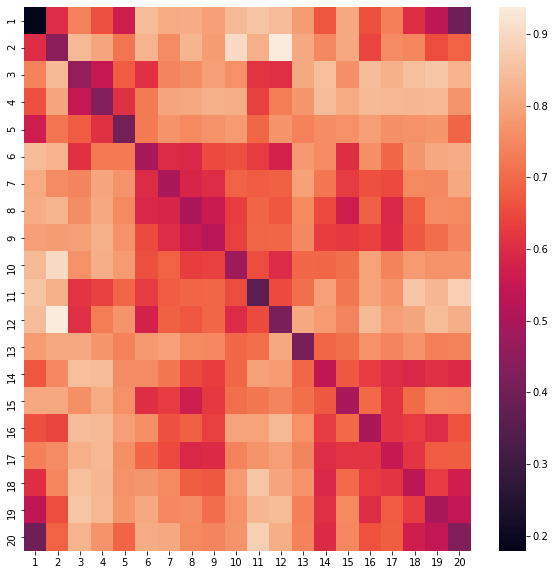

In [22]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(10,10))
sns.heatmap(matrix_cluster_dist)